In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import datetime
from os import path
from PIL import Image
from wordcloud import WordCloud
import requests
import json
import folium

from math import radians, sin, cos, asin, atan2, degrees, sqrt
from math import inf as INFINITY

from matplotlib import pyplot as plt
%matplotlib inline

print('Modules imported.')

Modules imported.


## Helper Functions

In [2]:
def get_parent_category(venue):
    venue=venue.lower()
    
    # Custom keyword categories
    food_keywords = ['cake', 'cream', 'noodle', 'subway', 'beer', 'taco', 'burrito', 'restaurant']
    professional_place_keywords = ['embassy', 'pharmacy']
    outdoor_place_keywords = ['gym', 'centre', 'center', 'sport', 'massage', 'spa', 'mall']
    place_of_worship_keywords = ['temple', 'church', 'mosque', 'shrine', 'synagogue']
    arts_entertainment_keywords = ['museum', 'planetarium', 'theater']
    travel_transport_keywords = ['rail', 'ferry', 'station', 'car']
    
    # Check Foursquare categories
    for cat in foursquare_categories:
        _cat = cat.lower()
        if (venue in foursquare_categories[cat]) or (venue in _cat):
            return cat
        # generic keywords
        if 'school' in venue:
            return 'College & University'
        if 'neighborhood' in venue or 'city' in venue:
            return 'Residence'
        
    # Check 'Food' items
    for item in food_keywords:
        if item in venue:
            return 'Food'
        
    # Check 'Professional & Other Places' items
    for item in professional_place_keywords:
        if item in venue:
            return 'Professional & Other Places'
        
    # Check 'Outdoors & Recreation' items
    for item in outdoor_place_keywords:
        if item in venue:
            return 'Outdoors & Recreation'
        
    # Check 'Place of Worship' items:
    for item in place_of_worship_keywords:
        if item in venue:
            return 'Place of Worship'
        
    # Check 'Arts & Entertainment':
    for item in arts_entertainment_keywords:
        if item in venue:
            return 'Arts & Entertainment'
        
    # Check 'Travel & Transport' items
    for item in travel_transport_keywords:
        if item in venue:
            return 'Travel & Transport'
    # 'Other'
    return 'Other'

In [3]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end
    
def getTimeCat(strUtcTime):    
    # extract time categories
    _time = datetime.datetime.strptime(strUtcTime, '%a %b %d %H:%M:%S %z %Y')
    ts = _time.time()

    # --> Morning = 0400-1000
    mornStart = datetime.time(4, 0, 1)
    mornEnd = datetime.time(10, 0, 0)

    # --> Midday = 1000-1600
    midStart = datetime.time(10, 0, 1)
    midEnd = datetime.time(16, 0, 0)

    # --> Evening = 1600-2200
    eveStart = datetime.time(16, 0, 1)
    eveEnd = datetime.time(22, 0, 0)

    # --> Late Night = 2200-0400
    lateStart = datetime.time(22, 0, 1)
    lateEnd = datetime.time(4, 0, 0)

    if time_in_range(mornStart, mornEnd, ts):
      timecat = 'Morning'
    elif time_in_range(midStart, midEnd, ts):
      timecat = 'Midday'
    elif time_in_range(eveStart, eveEnd, ts):
      timecat = 'Evening'
    elif time_in_range(lateStart, lateEnd, ts):
      timecat = 'Late Night'

    return timecat

In [4]:
def get_distance_btw_coords(coord_pairs, unit='mi'):
    '''
    description: Returns distance in 'mi' or 'km' between two coordinate points.
    params: coord_pairs (tuple) <- (latitude1, longitude1, latitude2, longitude2) in decimal            
            unit       (str) <- (default: 'mi':miles, else use 'km': kilometers)
    return: distance (float) -> returns distance

    reference: https://www.geeksforgeeks.org/program-distance-two-points-earth/#:~:text=For%20this%20divide%20the%20values,is%20the%20radius%20of%20Earth.
    '''
    lat1, lon1, lat2, lon2 = coord_pairs
    #lat1, lon1 = latlon1
    #lat2, lon2 = latlon2
    # First, convert the latitude and longitude values from decimal degrees to radians.
    lat1, lon1, lat2, lon2 = tuple(map(radians, (lat1, lon1, lat2, lon2)))

    # If we want to calculate the distance between two places in miles,
    # use the value '3,958.756', which is the radius of Earth; use '6,371' for kilometers (from Google).
    earth_radius = 3958.756 if unit.lower() == 'mi' else 6371

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    dist_rad = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    dist = 2 * asin(sqrt(dist_rad))

    # Return result
    return round(dist*earth_radius, 2)


def get_center_coords(coords_list):
    '''
    description: Returns the 'geographic midpoint' is calculated by finding the center of gravity
                 for the locations in the 'coordinate' list.
    params: coords_list (list) <- [(latitude, longitude), (latitude, longitude), ... ]; coordinates in decimal              
    return: coordinate (tuple) -> returns (latitude, longitude)

    reference: http://www.geomidpoint.com/calculation.html
    '''
    total_weight = len(coords_list)

    # Step 1: Convert coordinates to radians
    coords_list_radians = [(radians(x), radians(y)) for x, y in coords_list]

    # Step 2: Convert lat/lon to Cartesian coordinates viz: x,y,z
    #           X = cos(lat1) * cos(lon1)
    #           Y = cos(lat1) * sin(lon1)
    #           Z = sin(lat1)
    cartesian_coords_list = [(cos(lat) * cos(lon), cos(lat) * sin(lon), sin(lat))  # (X,Y,Z) tuple as described above
                             for lat, lon in coords_list_radians]

    # Step 3: Compute weighted average x, y and z coordinates
    x = np.average(
        np.asarray(list(_x for _x, _, _ in cartesian_coords_list)))/total_weight
    y = np.average(
        np.asarray(list(_y for _, _y, _ in cartesian_coords_list)))/total_weight
    z = np.average(
        np.asarray(list(_z for _, _, _z in cartesian_coords_list)))/total_weight

    # Step 4: Convert average x, y, z coordinate to latitude and longitude.
    _lon = atan2(y, x)
    _hyp = sqrt(x * x + y * y)
    _lat = atan2(z, _hyp)

    # Step 5: Convert lat and lon to degrees.
    lat = degrees(_lat)
    lon = degrees(_lon)

    # Return result
    return lat, lon


In [5]:
def flatten_coords_list(coords_list):
    '''
    description: recursively flatten list by iterating inner lists and returning coordinates tuples
    param: coords_list (list) <- list (of list ...) of coordinates
    returns: coords_list (list) -> single list of tuples(lat,lon)
    '''
    result = []
    if isinstance(coords_list, list):
        if (len(coords_list) == 2
            and isinstance(coords_list[0], float)
                and isinstance(coords_list[1], float)):
            return [tuple(coords_list)]
        if len(coords_list) > 0:
            for item in coords_list:
                result += flatten_coords_list(item)
            return result
    return coords_list

In [6]:
def get_normalized_coords(coords_list):
    '''
    description: Calculates the geographic midpoint from the list of coordinates
    params: (list) <- coords_list : list of tuples - [(lat,lon), ...]
    returns: (float, float) -> tuple of coordinates
    '''
    flattened_list = flatten_coords_list(coords_list)
    lat, lon = get_center_coords(flattened_list)
    return lat,lon

In [7]:
# Generate NYC Regions csv and put it in cache, return dataframe
def generate_nyc_regions():
    '''
    description: Generate NYC Regions csv and put it in cache
    return: DataFrame
    '''
    nyc_geojson_file = r'data/nyu_2451_34572-geojson.json'
    nyc_regions_csv = r'cache/nyc_regions.csv'
    # If file doen's exist, cache it for later use
    if not path.isfile(nyc_regions_csv):
        with open(nyc_geojson_file) as f:
            nyc_geojson = json.load(f)
            
        # define the dataframe columns
        column_names = ['Area', 'Neighborhood', 'Latitude', 'Longitude'] 

        # instantiate the dataframe
        neighborhoods = pd.DataFrame(columns=column_names)
        for data in nyc_geojson['features']:
            borough = data['properties']['borough'] 
            neighborhood_name = data['properties']['name']

            neighborhood_latlon = data['geometry']['coordinates']
            neighborhood_lat = neighborhood_latlon[1]
            neighborhood_lon = neighborhood_latlon[0]

            neighborhoods = neighborhoods.append({'Area': borough,
                                                  'Neighborhood': neighborhood_name,
                                                  'Latitude': neighborhood_lat,
                                                  'Longitude': neighborhood_lon}, ignore_index=True)
        
        # Cache to a file
        neighborhoods.to_csv(nyc_regions_csv, index=False)
        print('Created {}'.format(nyc_regions_csv))
    
    # Return dataframe
    return pd.read_csv(nyc_regions_csv)


# Generate TYO Regions csv and put it in cache, return dataframe
def generate_tyo_regions():
    '''
    description: # Generate TYO Regions csv and put it in cache
    return: DataFrame
    '''
    tyo_geojson_file = r'data/tokyo.geojson'
    tyo_regions_csv = r'cache/tyo_regions.csv'
    # If file doen's exist, cache it for later use
    if not path.isfile(tyo_regions_csv):
        with open(tyo_geojson_file) as f:
            tyo_geojson = json.load(f)
            
        # define the dataframe columns
        column_names = ['Area', 'Neighborhood', 'Latitude', 'Longitude'] 

        # instantiate the dataframe
        neighborhoods = pd.DataFrame(columns=column_names)
        for item in tyo_geojson['features']:
            area, ward, coords_list = (item['properties']['area_en']
                       ,item['properties']['ward_en']
                       ,item['geometry']['coordinates'])
            if area and ward and coords_list:
                lat, lon = get_normalized_coords(coords_list)
                neighborhoods = neighborhoods.append({'Area': area,
                                                      'Neighborhood': ward,
                                                      'Latitude': lat,
                                                      'Longitude': lon}, ignore_index=True)
            else:
                # Skip unavailable data
                pass
            
        
        # Cache to a file
        neighborhoods.to_csv(tyo_regions_csv, index=False)
        print('Created {}'.format(tyo_regions_csv))
    
    # Return dataframe
    return pd.read_csv(tyo_regions_csv)

## Data Preprocessing

#### Define Category Type

In [8]:
# !!!! REMOVE !!!!
CLIENT_ID = 'IRB0HMTHV5NYWZNYWNPATNL5F0MWSUDHJRIEOFYE2WZ34T5R' # your Foursquare ID
CLIENT_SECRET = 'TDTUK5GY4OSQHCPPQQLJG0XYPOAVRV1G0R32BNUX4J0Q0U1E' # your Foursquare Secret
VERSION = '20200525' # Foursquare API version

In [9]:
# Fetch Foursquare categories
endpoint = 'https://api.foursquare.com/v2/venues/categories'

params = dict(
client_id=CLIENT_ID,
client_secret=CLIENT_SECRET,
v=VERSION
)

# Hit endpoint
response = (requests.get(endpoint, params=params)).json()

# Categories Dictionary
foursquare_categories = {}
for parent_cat in response['response']['categories']:
    foursquare_categories[parent_cat['name']]=set()
    for cat in parent_cat['categories']:
        foursquare_categories[parent_cat['name']].add(cat['name'].lower().strip())
    

### DataFrames

In [10]:
# Datasets
nyc_csv = r"data/dataset_TSMC2014_NYC.csv"
tky_csv = r"data/dataset_TSMC2014_TKY.csv"

In [11]:
nyc = pd.read_csv(nyc_csv)
tky = pd.read_csv(tky_csv)

In [12]:
nyc_neighborhoods = generate_nyc_regions()
neighborhood_df = nyc_neighborhoods[['Latitude','Longitude']]
def get_region_csv_str(lat, lon):
    latlon_series = neighborhood_df.apply(lambda x: (x['Latitude'], x['Longitude'], lat,lon), axis=1)
    res = latlon_series.apply(get_distance_btw_coords)
    # Get row which is closest w.r.t distance
    idx=res.idxmin()    
    row = nyc_neighborhoods.iloc[idx:idx+1,]
    # Return only area and neighborhood
    return row.values.tolist()[0][:2]

In [13]:
nyc['RegionInfo'] = nyc.apply(lambda _df: get_region_csv_str(_df['latitude'], _df['longitude']), axis=1)

In [19]:
# Merge Columns
nyc_1=nyc[list(nyc.columns[:-1])]
nyc_2=nyc[list(nyc.columns[-1:])]
nyc_2 = pd.DataFrame(list(nyc_2['RegionInfo']),
                                 columns = list(nyc_neighborhoods.columns[:2]))
nyc = pd.concat([nyc_1, nyc_2], axis=1)

In [21]:
nyc.to_csv('cache/nyc.csv', index=False)

In [22]:
tyo_neigborhoods = generate_tyo_regions()
neighborhood_df = tyo_neigborhoods[['Latitude','Longitude']]
def get_region_csv_str(lat, lon):
    latlon_series = neighborhood_df.apply(lambda x: (x['Latitude'], x['Longitude'], lat,lon), axis=1)
    res = latlon_series.apply(get_distance_btw_coords)
    # Get row which is closest w.r.t distance
    idx=res.idxmin()    
    row = tyo_neigborhoods.iloc[idx:idx+1,]
    # Return only area and neighborhood
    return row.values.tolist()[0][:2]

In [23]:
tky['RegionInfo'] = tky.apply(lambda _df: get_region_csv_str(_df['latitude'], _df['longitude']), axis=1)

In [24]:
# Merge Columns
tky_1=tky[list(tky.columns[:-1])]
tky_2=tky[list(tky.columns[-1:])]
tky_2 = pd.DataFrame(list(tky_2['RegionInfo']),
                                 columns = list(tyo_neigborhoods.columns[:2]))
tky = pd.concat([tky_1, tky_2], axis=1)

In [25]:
tky.to_csv('cache/tky.csv', index=False)

In [26]:
# Add cityCode column
nyc['cityCode'] = 'NYC'
tky['cityCode'] = 'TYO'

In [27]:
# Stack the DataFrames on top of each other
df = pd.concat([nyc, tky], axis=0)

In [28]:
# Rename columns
df.rename(columns={'utcTimestamp':'checkInUtcTimestamp', 'Area':'area', 'Neighborhood':'neighborhood'}
          , inplace=True)

In [29]:
# Drop venueId and venueCategoryId (since we already have coordinates and venueName)
# Drop timezoneOffset (since the comparison will be in relative time per city)
df.drop(columns=['timezoneOffset','venueId', 'venueCategoryId'], inplace=True)

In [30]:
# Add 'Venue Type' column
df['venueType'] = df['venueCategory'].apply(get_parent_category)

In [31]:
# Add 'timeCategory' representing: morning, midday, evening, and late night
df['timeCategory'] = df['checkInUtcTimestamp'].apply(getTimeCat)

In [32]:
# Add natural order to 'timeCategory'
df['timeCategory']=df['timeCategory'].astype(CategoricalDtype(categories=['Morning','Midday','Evening','Late Night']
                                           ,ordered=True))

In [33]:
# Rearrange columns
rearrangedCols = ['userId', 'cityCode', 'area', 'neighborhood',
                  'venueType', 'venueCategory',
                  'timeCategory', 'checkInUtcTimestamp',
                  'latitude', 'longitude']
df = df[rearrangedCols]

In [36]:
# Save updated dataset : REMOVE OR HIDE LATER
# df.to_csv('cache/df.csv', index=False)

## Start from here

In [38]:
# Use cached copies of updated datasets to avoid re-running. 
df_csv = r"cache/df.csv"
df = pd.read_csv(df_csv)
#df.drop(columns=['Unnamed: 0'], inplace=True)

In [39]:
print(df.shape)
df.head()

(801131, 10)


,userId,cityCode,area,neighborhood,venueType,venueCategory,timeCategory,checkInUtcTimestamp,latitude,longitude
0,470,NYC,Manhattan,Soho,Shop & Service,Arts & Crafts Store,Evening,Tue Apr 03 18:00:09 +0000 2012,40.719810,-74.002581
1,979,NYC,Brooklyn,Fort Hamilton,Outdoors & Recreation,Bridge,Evening,Tue Apr 03 18:00:25 +0000 2012,40.606800,-74.044170
2,69,NYC,Queens,Middle Village,Residence,Home (private),Evening,Tue Apr 03 18:02:24 +0000 2012,40.716162,-73.883070
3,395,NYC,Manhattan,Murray Hill,Professional & Other Places,Medical Center,Evening,Tue Apr 03 18:02:41 +0000 2012,40.745164,-73.982519
4,87,NYC,Manhattan,Flatiron,Food,Food Truck,Evening,Tue Apr 03 18:03:00 +0000 2012,40.740104,-73.989658


In [40]:
# Create City Masks for filtering
nyc = df['cityCode']=='NYC'
tyo = df['cityCode']=='TYO'

## Visualization

#### _Word Clouds_

In [43]:
wordcloud = WordCloud(background_color='white', width=800, height=400)

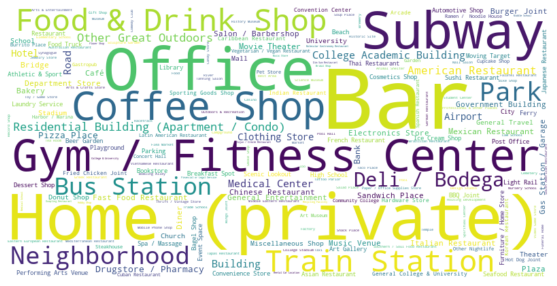

In [44]:
# NYC Venue Categories
nyc_word_cloud = wordcloud.generate_from_frequencies(df[nyc].groupby('venueCategory').size().to_dict())
plt.figure(figsize=(10,5))
plt.imshow(nyc_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('img/NYC_Venue_Categories.png')
plt.show()

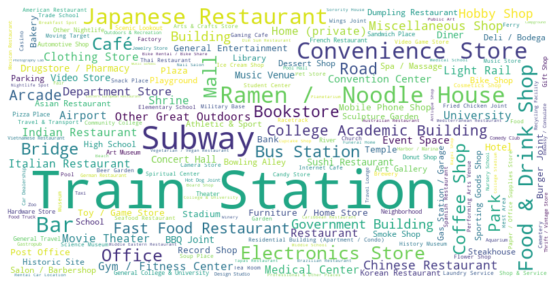

In [45]:
# TKY Venue Categories
tyo_word_cloud = wordcloud.generate_from_frequencies(df[tyo].groupby('venueCategory').size().to_dict())
plt.figure(figsize=(10,5))
plt.imshow(tyo_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('img/TYO_Venue_Categories.png')
plt.show()

#### _Venue Types_ Distribution

In [46]:
# Venue Types
nyc_venue_types = df[nyc].groupby('venueType').size()
tyo_venue_types = df[tyo].groupby('venueType').size()

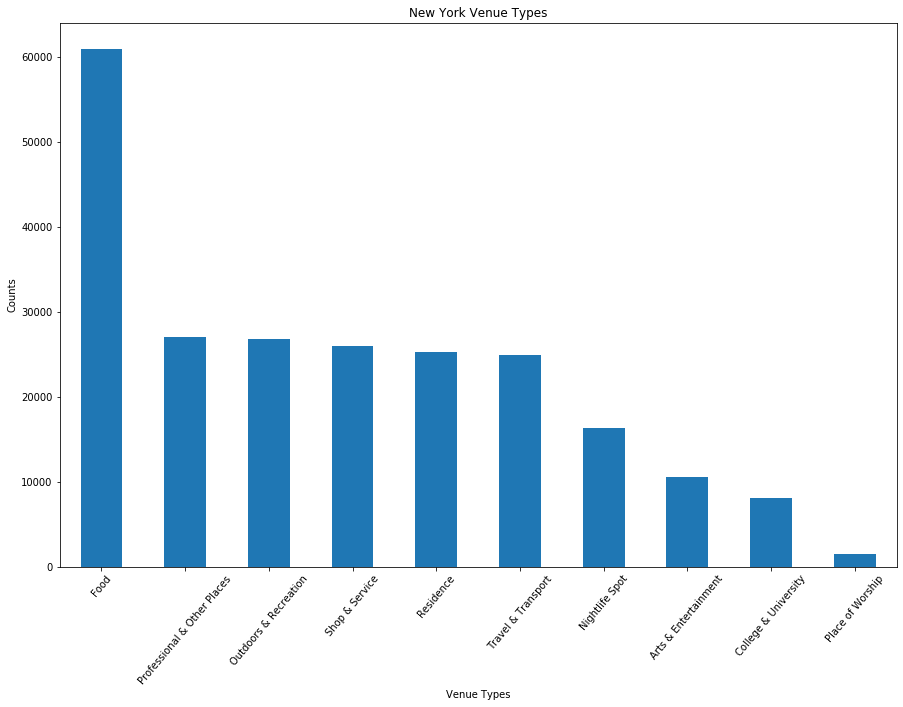

In [47]:
# NYC Venue Types
plt.figure(figsize=(15,10))
nyc_venue_types.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel('Venue Types')
plt.ylabel('Counts')
plt.title('New York Venue Types')
plt.savefig('img/NYC_Venue_Types.png')
plt.show()

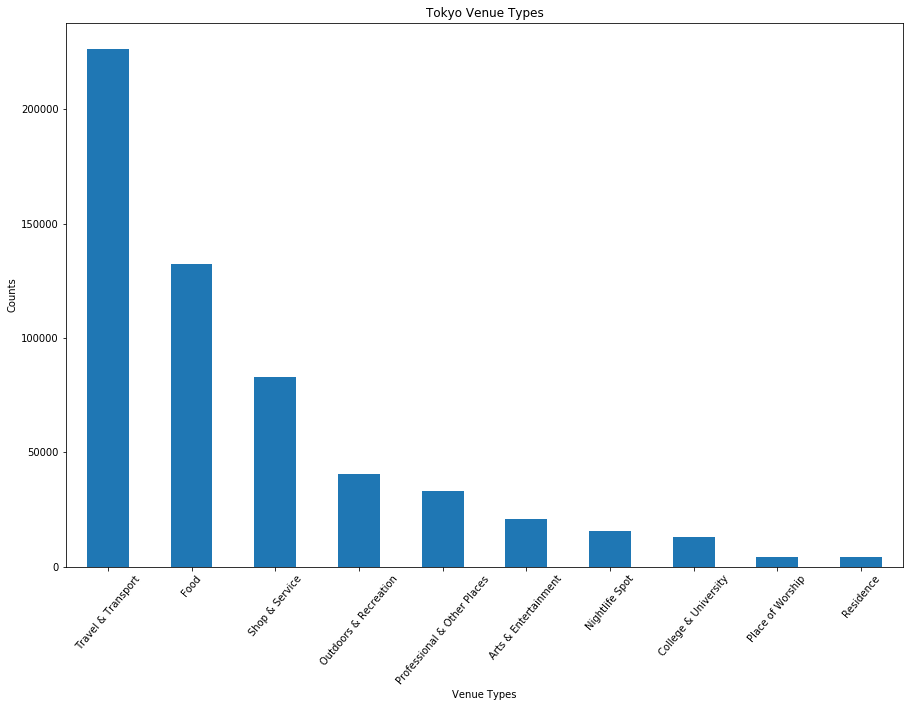

In [48]:
# TKY Venue Types
plt.figure(figsize=(15,10))
tyo_venue_types.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel('Venue Types')
plt.ylabel('Counts')
plt.title('Tokyo Venue Types')
plt.savefig('img/TYO_Venue_Types.png')
plt.show()

#### _Time of the Day_ Distribution

In [49]:
# Venue Types
nyc_timeCategories = df[nyc].groupby('timeCategory').size()
tyo_timeCategories = df[tyo].groupby('timeCategory').size()

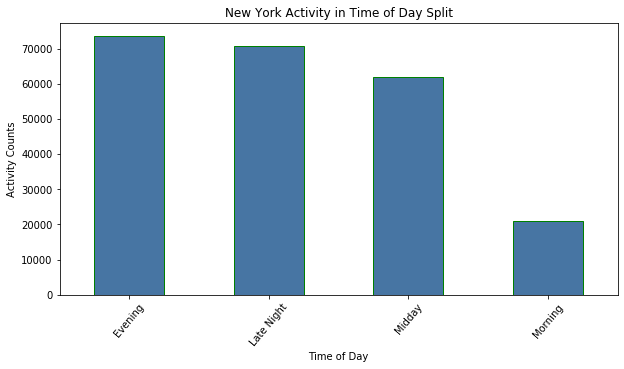

In [50]:
# NYC Venue Types
plt.figure(figsize=(10,5))
nyc_timeCategories.plot.bar(color=(0.2, 0.4, 0.6, 0.9),  edgecolor='green')
plt.xticks(rotation=50)
plt.xlabel('Time of Day')
plt.ylabel('Activity Counts')
plt.title('New York Activity in Time of Day Split')
plt.savefig('img/NYC_TimeCategory.png')
plt.show()

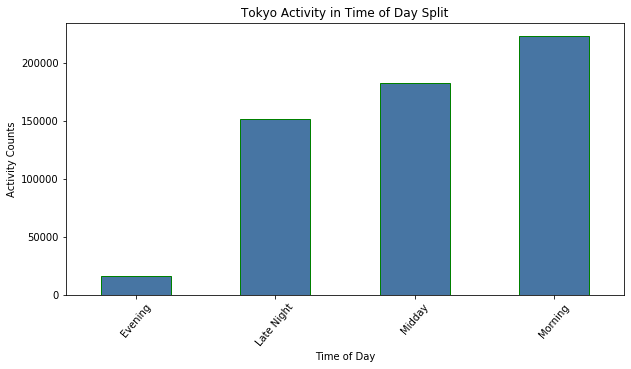

In [51]:
# TYO Venue Types
plt.figure(figsize=(10,5))
tyo_timeCategories.plot.bar(color=(0.2, 0.4, 0.6, 0.9),  edgecolor='green')
plt.xticks(rotation=50)
plt.xlabel('Time of Day')
plt.ylabel('Activity Counts')
plt.title('Tokyo Activity in Time of Day Split')
plt.savefig('img/TYO_TimeCategory.png')
plt.show()

#### `Choropleth` maps

In [ ]:
#world_geojson['features'][0]

In [ ]:
# create a plain world map
world_map = folium.Map(location=[0, 0], zoom_start=2, tiles='Mapbox Bright')

In [ ]:
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
world_map.choropleth(
    geo_data=world_geojson_file,
    data=c,
    columns=['Country','Count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Immigration to Canada'
)

# display map
#world_map